# Implementing linear optics

In [2]:
import numpy as np
from discopy import optics
from discopy.optics import Id, MZI, PhaseShift, BeamSplitter

Build an optical network using beam splitters, phase shifters and Mach-Zender interferometers.

Build a simple optical network:


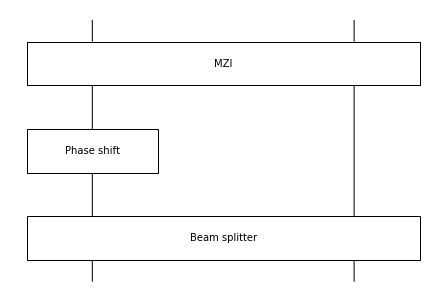

In [3]:
print("Build a simple optical network:")

network = lambda x: MZI(x[0], x[1]) >> PhaseShift(x[2]) @ Id(1) >>  BeamSplitter(x[3])

network([0.2, 0.4, 0.5, 0.7]).draw(draw_type_labels=False)

In [7]:
print("Initialise random parameters for the network:")
x = np.random.uniform(low=0.0, high=2*np.pi, size=4)
print(x)

print("Compute the amplitude with 3 photons, input [1, 2] and output [2, 1]:")
amplitude = network(x).amp(3, [1, 2], [2, 1])
print(amplitude)
 
print("\nCompute the output distribution with input [1, 2]")
probs = []
for i in range(4):
    amplitude = network(x).amp(3, [1, 2], [i, 3 - i])
    prob = np.absolute(amplitude) ** 2
    print([i, 3 - i], prob)
    probs += [prob]
assert np.allclose(sum(probs), 1.)

Initialise random parameters for the network:
[4.82345323 0.00578546 3.95977131 3.84342133]
Compute the amplitude with 3 photons, input [1, 2] and output [2, 1]:
(-0.5926548327216249-0.10625315212392426j)

Compute the output distribution with input [1, 2]
[0, 3] 0.037692776726339264
[1, 2] 0.321921871411266
[2, 1] 0.36252948308456695
[3, 0] 0.2778558687778274


We now build the Vienna chip of https://www.nature.com/articles/s41534-019-0179-2

In [8]:
def build_vienna_chip(params):   
    chip = Id(26)
    for i in range(11):
        boxes = Id()
        for j in range(3 + i):
            boxes = boxes @ MZI(*params[i, j])
        chip = chip >> Id(10 - i) @ boxes @ Id(10 - i)
    return chip

Initialise the chip with random parameters


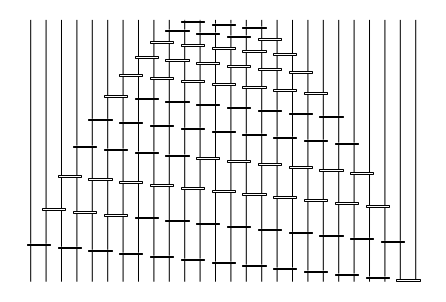

In [9]:
print("Initialise the chip with random parameters")
params = np.random.rand(11, 13, 2)
chip = build_vienna_chip(params)
chip.draw(draw_type_labels=False, draw_box_labels=False)

In [10]:
n_photons = 4
x = [0 for i in range(10)] + [0, 0, 1, 3, 0, 0] + [0 for i in range(10)] # input occupation numbers
y = [0 for i in range(10)] + [0, 1, 0, 2, 1, 0] + [0 for i in range(10)] # output occupation numbers

amplitude = chip.amp(n_photons, x, y)

print("Calculate the amplitude of an input-output pair with 4 photons:")
print(amplitude)

Calculate the amplitude of an input-output pair with 4 photons:
(0.0006555262666523419-0.0004666096929114741j)


We can also use thewalrus for the computation of the permanent

In [15]:
import thewalrus
from thewalrus import perm

chip.amp(n_photons, x, y, permanent=perm)

(-0.00042703368462758125+0.0001325159839002238j)

In [16]:
# Given width and depth this code builds an array of Mach Zender interferometers

def build_chip(width, depth, params):   
    chip = Id(width)
    if width % 2 == 0:
        for i in range(depth):
            boxes = Id()
            if i % 2 == 0:
                for j in range(int(width / 2)):
                    boxes =  boxes @ MZI(*params[i, j])
            else:
                for j in range(int(width / 2) - 1):
                    boxes = boxes @ MZI(*params[i, j])
                boxes = Id(1) @ boxes @ Id(1)
            chip = chip >> boxes
    else: 
        for i in range(depth):
            boxes = Id()
            for j in range(int(width / 2)):
                    boxes =  boxes @ MZI(*params[i, j])  
            if i % 2 == 0:
                boxes = boxes @ Id(1)
            else:
                boxes = Id(1) @ boxes
            chip = chip >> boxes
    return chip

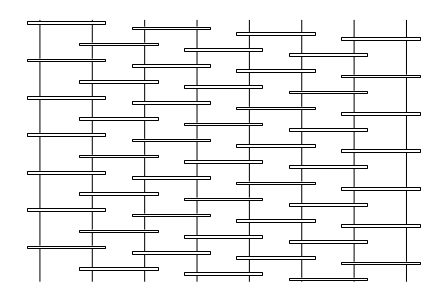

In [18]:
width = 8
depth = 14
params = np.random.rand(depth, int(width / 2), 2)
chip = build_chip(width, depth, params)
chip.draw(draw_type_labels=False, draw_box_labels=False)